## XGBoost Regressor

In this notebook, we train an XGBoost regression model to predict the Remaining Useful Life (RUL) of engines in the FD001 dataset from C-MAPSS.

XGBoost is a gradient boosting algorithm that performs well on structured, tabular data and is particularly effective in modeling complex nonlinear relationships.

Our objective is to estimate the RUL at the final recorded cycle for each engine in the test set, using sensor measurements and operational settings. This model is evaluated using standard regression metrics such as MAE, RMSE, and R².


In [1]:
import xgboost as xgb
from xgboost import XGBRegressor
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import numpy as np
from pathlib import Path

project_root = Path().resolve().parents[1]
sys.path.append(str(project_root))

from scripts.add_rul_column import add_rul_column
from scripts.get_last_cycle_per_unit import get_last_cycle_per_unit
from scripts.evaluate_regression import evaluate_regression

In [2]:
# Load the dataset
test_data = pd.read_csv('../../data/raw/test_FD001.txt', sep=' ', header=None)
train_data = pd.read_csv('../../data/raw/train_FD001.txt', sep=' ', header=None)
rul_data = pd.read_csv("../../data/raw/rul_FD001.txt", header=None, names=["rul"])

In [3]:
train_data.dropna(axis=1, how='all', inplace=True) # Drop columns with all NaN values
cols = ['unit', 'cycle'] + [f'op_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 22)] # Column names
train_data.columns = cols

train_data.head()

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
rul_data.head()

,rul
0,112
1,98
2,69
3,82
4,91


In [5]:
# Drop useless columns
drop_columns_list = ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']

train_data.drop(columns=drop_columns_list, inplace=True)

In [6]:
# split for model training and testing
X = train_data.drop(columns=['unit', 'cycle'])
train_data = add_rul_column(train_data)
y = train_data['rul']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train shape: (16504, 16)
X_test shape: (4127, 16)
y_train: (16504,)
y_test: (4127,)


In [7]:
# Scale the features
scaler = MinMaxScaler()

# Add RUL
train_data = add_rul_column(train_data)

# Prepare full training dataset
X_full = train_data.drop(columns=['unit', 'cycle', 'rul'])
y_full = train_data['rul']

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [8]:
eval_data = get_last_cycle_per_unit(train_data)
X_eval = eval_data.drop(columns=['unit', 'cycle', 'rul'])
y_eval = eval_data['rul']
X_eval_scaled = scaler.transform(X_eval)

In [25]:
print(y_eval.describe())
print(y_eval.unique())


count    100.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: rul, dtype: float64
[0]


In [10]:
""" # Custom RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# Base model
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)

# Parameter grid
param_dist = {
    "n_estimators": [100, 300, 500, 1000],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7, 10],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [1.0, 1.5, 2.0]
}

# Randomized search setup
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=25,
    scoring=rmse_scorer,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run search on scaled training data
random_search.fit(X_train_scaled, y_train)

# Output results
print("Best RMSE score:", -random_search.best_score_)  # Flip sign due to greater_is_better=False
print("Best parameters:", random_search.best_params_) """


' # Custom RMSE scorer\nrmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)\n\n# Base model\nxgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)\n\n# Parameter grid\nparam_dist = {\n    "n_estimators": [100, 300, 500, 1000],\n    "learning_rate": [0.01, 0.05, 0.1, 0.2],\n    "max_depth": [3, 5, 7, 10],\n    "min_child_weight": [1, 3, 5],\n    "subsample": [0.6, 0.8, 1.0],\n    "colsample_bytree": [0.6, 0.8, 1.0],\n    "reg_alpha": [0, 0.1, 0.5],\n    "reg_lambda": [1.0, 1.5, 2.0]\n}\n\n# Randomized search setup\nrandom_search = RandomizedSearchCV(\n    estimator=xgb_model,\n    param_distributions=param_dist,\n    n_iter=25,\n    scoring=rmse_scorer,\n    cv=3,\n    verbose=1,\n    random_state=42,\n    n_jobs=-1\n)\n\n# Run search on scaled training data\nrandom_search.fit(X_train_scaled, y_train)\n\n# Output results\nprint("Best RMSE score:", -random_search.best_score_)  # Flip sign due to greater_is_better=False\nprint("Best para

### Model Trained

The XGBoost Regressor was trained using all relevant operational and sensor features. Hyperparameters were optimized via randomized search with 3-fold cross-validation, targeting RMSE as the scoring metric. The final model uses the best-performing parameters found during the search.

In [11]:
params = { 
    'subsample': 0.8,
    'reg_lambda': 2.0,
    'reg_alpha': 0.1,
    'n_estimators': 500,
    'min_child_weight': 1,
    'early_stopping_rounds': 50,
    'max_depth': 5,
    'learning_rate': 0.01,
    'colsample_bytree': 0.8
 }

In [12]:
xgb_best = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    **params
)

xgb_best.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=True
)


[0]	validation_0-rmse:67.20968
[1]	validation_0-rmse:66.81919
[2]	validation_0-rmse:66.43865
[3]	validation_0-rmse:66.06074
[4]	validation_0-rmse:65.68687
[5]	validation_0-rmse:65.31945
[6]	validation_0-rmse:64.96144
[7]	validation_0-rmse:64.60313
[8]	validation_0-rmse:64.24936
[9]	validation_0-rmse:63.90937
[10]	validation_0-rmse:63.57112
[11]	validation_0-rmse:63.23193
[12]	validation_0-rmse:62.89854
[13]	validation_0-rmse:62.56983
[14]	validation_0-rmse:62.25259
[15]	validation_0-rmse:61.92932
[16]	validation_0-rmse:61.61423
[17]	validation_0-rmse:61.30264
[18]	validation_0-rmse:60.99448
[19]	validation_0-rmse:60.69053
[20]	validation_0-rmse:60.39480
[21]	validation_0-rmse:60.11005
[22]	validation_0-rmse:59.81656
[23]	validation_0-rmse:59.53084
[24]	validation_0-rmse:59.24636
[25]	validation_0-rmse:58.96589
[26]	validation_0-rmse:58.69020
[27]	validation_0-rmse:58.42197
[28]	validation_0-rmse:58.15334
[29]	validation_0-rmse:57.88814
[30]	validation_0-rmse:57.63090
[31]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [13]:
# Clean test data
test_data.dropna(axis=1, inplace=True)
test_data.columns = ['unit', 'cycle'] + [f'op_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 22)]
test_data.drop(columns=drop_columns_list, inplace=True)

# Keep only last cycle
test_last = get_last_cycle_per_unit(test_data)
test_last['rul'] = rul_data['rul']

X_test_final = test_last.drop(columns=['unit', 'cycle', 'rul'])
y_test_final = test_last['rul']
X_test_final_scaled = scaler.transform(X_test_final)

y_test_final_pred = xgb_best.predict(X_test_final_scaled)



In [14]:
evaluate_regression(y_test_final, y_test_final_pred, "XGBoost")


XGBoost MAE:  23.75
XGBoost RMSE: 32.13
XGBoost R²:   0.40


## XGBoost Evaluation Summary - Regression

- **Model:** XGBoost Regressor
- **Input Features:** Operational settings + filtered sensors
- **Target: RUL** (Remaining Useful Life)
---
- **MAE:** 23.75
- **RMSE:** 32.13
- **R² Score:** 0.40

Sensor 9 and sensor 14 emerged as the most critical contributors to the model, surpassing sensor 11, which was dominant in the Random Forest model. The XGBoost model shows stronger generalization capacity, capturing degradation trends more effectively across engine instances. Lower error metrics and more stable predictions on the test set highlight its advantage, though R² still indicates room for improvement.

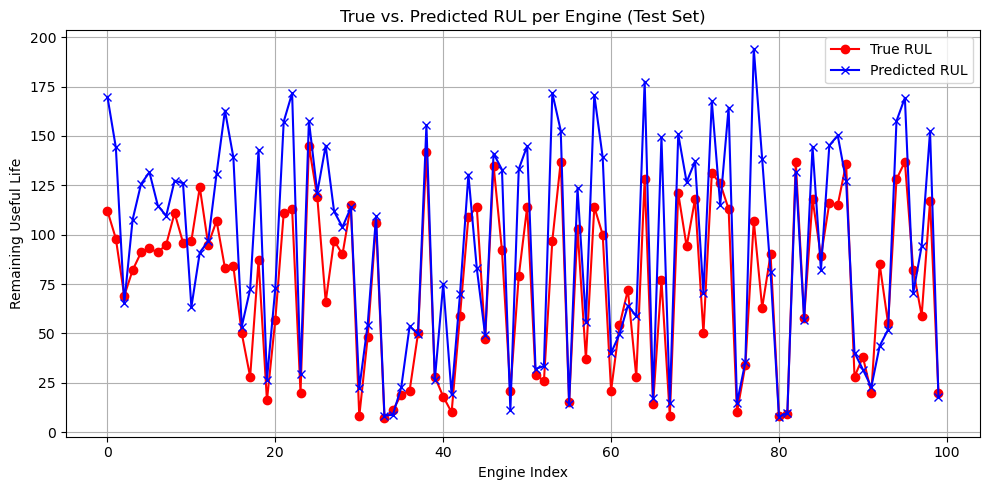

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_final.values, label="True RUL", color="red", marker='o')
plt.plot(y_test_final_pred, label="Predicted RUL", color="blue", marker='x')
plt.legend()
plt.title("True vs. Predicted RUL per Engine (Test Set)")
plt.xlabel("Engine Index")
plt.ylabel("Remaining Useful Life")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.show()


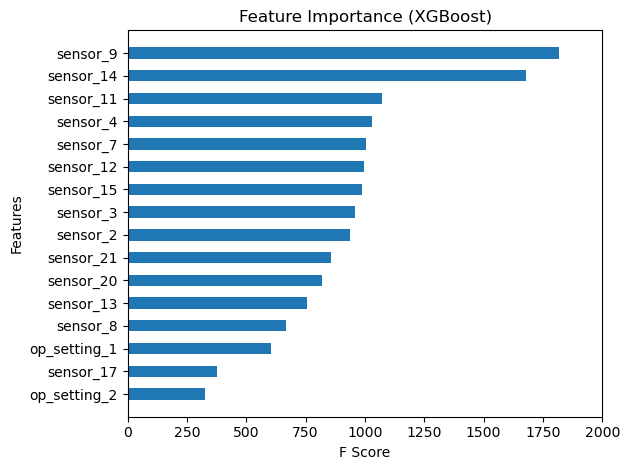

In [16]:
xgb_best.get_booster().feature_names = X_train.columns.tolist()

xgb.plot_importance(
    xgb_best,
    importance_type='weight',
    title='Feature Importance (XGBoost)',
    xlabel='F Score',
    ylabel='Features',
    grid=False,
    show_values=False,
    height=0.5,
    max_num_features=20
)
plt.tight_layout()
plt.show()

## Residual Analysis
The residuals represent the difference between true and predicted RUL values on the evaluation set. As shown in the residual plot, almost all true RUL values are zero, corresponding to the engines' final cycle. This creates a vertically aligned cluster of residuals, highlighting that most predictions underestimate the remaining useful life. These consistent underestimations align with the modest RMSE and relatively low variance explained (R²), suggesting the model tends to be conservative in predicting failure proximity.

## Error Distribution
The prediction error histogram reveals a right-skewed distribution, with the majority of errors ranging between 6 and 10 cycles. The peak centered around 7 cycles indicates that the model consistently overestimates the remaining useful life (RUL), predicting engines will last longer than they actually do. This systemic bias toward overestimation poses a risk in safety-critical applications, where premature failures can be costly or hazardous. The smooth KDE overlay confirms the stability of the error distribution and the absence of extreme outliers, but also highlights a persistent model blind spot. Compared to the Random Forest baseline, XGBoost shows tighter generalization but requires further calibration to improve reliability in end-of-life predictions.

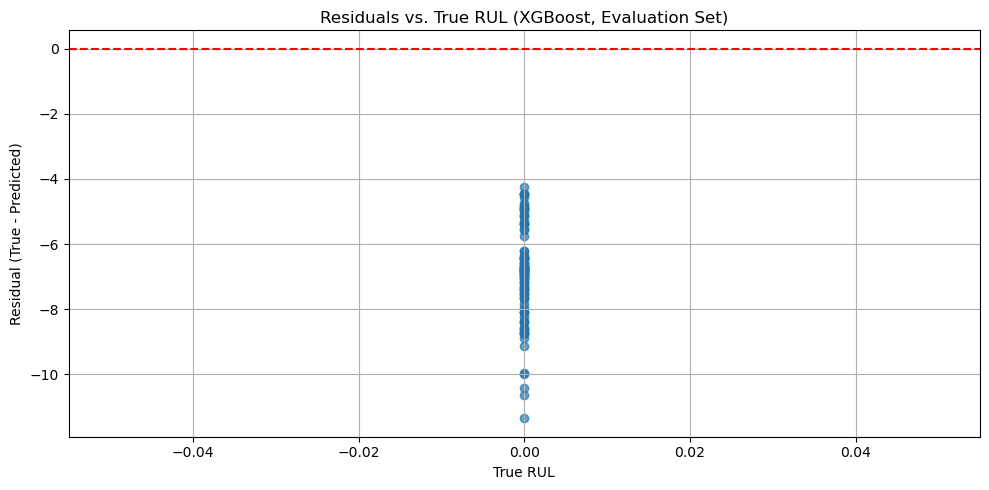

In [17]:
y_eval_pred = xgb_best.predict(X_eval_scaled) # Predict on evaluation set
# Calculate residuals
residuals_xgb = y_eval - y_eval_pred

# Scatter plot of residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_eval, residuals_xgb, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. True RUL (XGBoost, Evaluation Set)")
plt.xlabel("True RUL")
plt.ylabel("Residual (True - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()


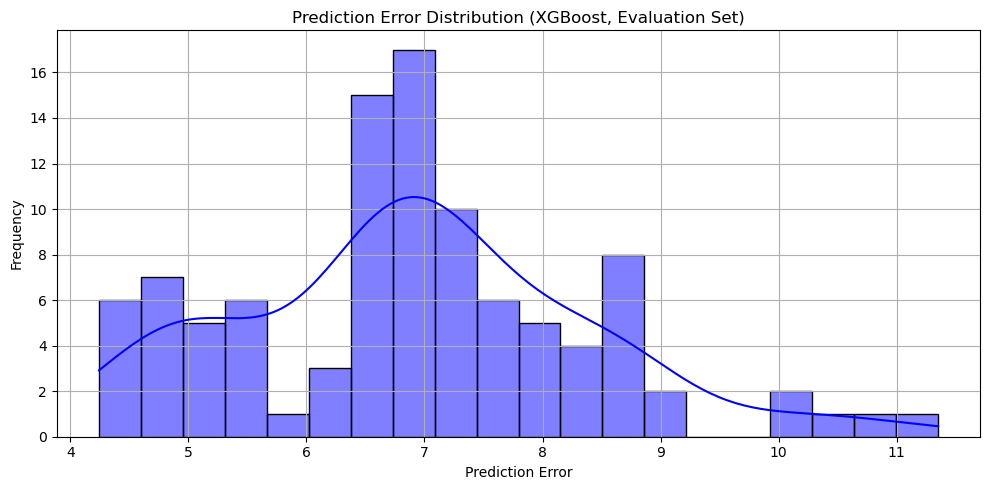

In [18]:
# Distribution of prediction errors
errors_xgb = y_eval_pred - y_eval

plt.figure(figsize=(10, 5))
sns.histplot(errors_xgb, kde=True, bins=20, color='blue')
plt.title("Prediction Error Distribution (XGBoost, Evaluation Set)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
def asymmetric_loss_overestimation(y_true, y_pred):
    residual = y_pred - y_true
    grad = np.where(residual > 0, 2 * residual, residual)         # Heavier gradient for overestimation
    hess = np.where(residual > 0, 2.0, 1.0)                       # Heavier curvature for overestimation
    return grad, hess

In [20]:
xgb_custom = XGBRegressor(
    objective=asymmetric_loss_overestimation,
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    reg_alpha=0.1,
    random_state=42
)

xgb_custom.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=True
)


[0]	validation_0-rmse:126.53177
[1]	validation_0-rmse:125.40822
[2]	validation_0-rmse:124.30575
[3]	validation_0-rmse:123.20850
[4]	validation_0-rmse:122.12674
[5]	validation_0-rmse:121.05648
[6]	validation_0-rmse:120.00858
[7]	validation_0-rmse:118.95707
[8]	validation_0-rmse:117.92333
[9]	validation_0-rmse:116.89818
[10]	validation_0-rmse:115.88756
[11]	validation_0-rmse:114.88813
[12]	validation_0-rmse:113.89772
[13]	validation_0-rmse:112.91847
[14]	validation_0-rmse:111.95793
[15]	validation_0-rmse:110.99445
[16]	validation_0-rmse:110.05353
[17]	validation_0-rmse:109.11788
[18]	validation_0-rmse:108.19387
[19]	validation_0-rmse:107.27831
[20]	validation_0-rmse:106.37803
[21]	validation_0-rmse:105.49433
[22]	validation_0-rmse:104.60757
[23]	validation_0-rmse:103.73122
[24]	validation_0-rmse:102.87006
[25]	validation_0-rmse:102.01978
[26]	validation_0-rmse:101.17383
[27]	validation_0-rmse:100.34374
[28]	validation_0-rmse:99.51767
[29]	validation_0-rmse:98.70384
[30]	validation_0-rmse

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None,
             objective=<function asymmetric_loss_overestimation at 0x0000020DEC9A4540>, ...)

In [21]:
y_val_custom_pred = xgb_custom.predict(X_val_scaled)
evaluate_regression(y_val, y_val_custom_pred, label="Validation (Penalty Applied)")


Validation (Penalty Applied) MAE:  29.14
Validation (Penalty Applied) RMSE: 42.13
Validation (Penalty Applied) R²:   0.61


## Optional Penalization
We can optionally penalize the model for overestimating the RUL. This is particularly useful in safety-critical applications where underestimating the RUL is more acceptable than overestimating it. By applying a penalty to the model's predictions, we can adjust the error distribution and improve the model's reliability in predicting engine failures.

## Residual Analysis (Overestimation Penalty)
The residual plot after applying an overestimation penalty reveals a significant change in model behavior. Residuals are now well-distributed across the RUL range, unlike the near-zero collapse observed earlier. This indicates the model is no longer underestimating consistently but instead overpredicts RUL more frequently, especially at higher cycle counts. While this introduces a degree of variance, it aligns better with a safety-first strategy where premature maintenance is preferable to unexpected failures.

## Error Distribution (w/ Overestimation Penalty)
The updated error distribution confirms this behavior. The histogram shows a long negative tail, reflecting numerous instances where predicted RUL exceeds actual RUL. This aligns with the models new tendency to err on the side of overestimation, reinforcing the effect of the custom loss function and highlighting the tunable nature of predictive confidence in deployment scenarios.

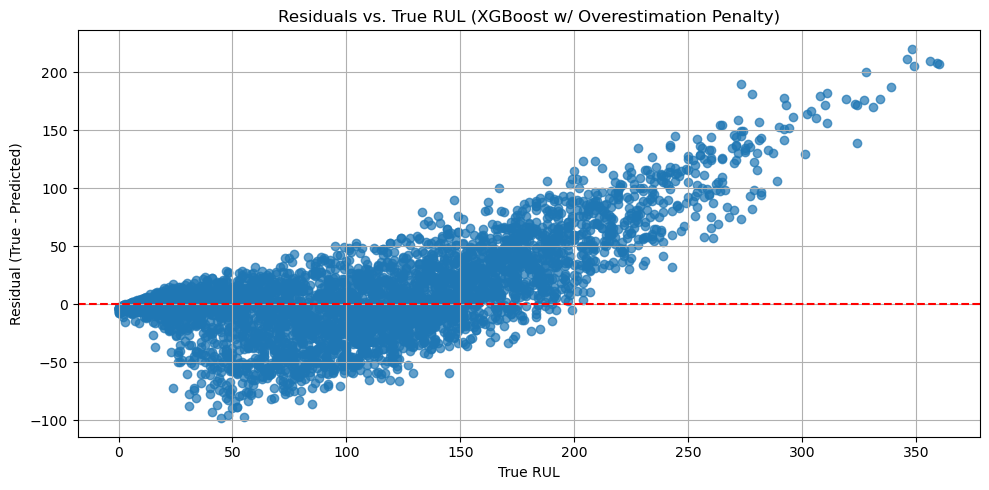

In [22]:
residuals_custom = y_val - y_val_custom_pred

plt.figure(figsize=(10, 5))
plt.scatter(y_val, residuals_custom, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. True RUL (XGBoost w/ Overestimation Penalty)")
plt.xlabel("True RUL")
plt.ylabel("Residual (True - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()


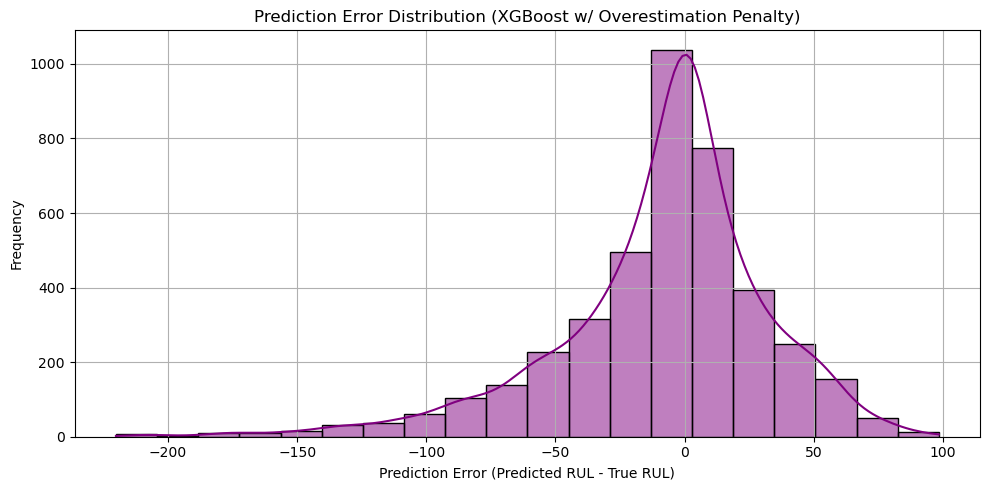

In [23]:
errors_custom = y_val_custom_pred - y_val

plt.figure(figsize=(10, 5))
sns.histplot(errors_custom, kde=True, bins=20, color='purple')
plt.title("Prediction Error Distribution (XGBoost w/ Overestimation Penalty)")
plt.xlabel("Prediction Error (Predicted RUL - True RUL)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()